- GitHub: https://github.com/mahmood1989?tab=repositories
- Email: mahmoodr@ualberta.ca

## Classification of CT-Scan images into COVID and non-COVID classes
## Transfer learning using DenseNet121 & InceptionV3

Here is the link of these two convolutional Neural Networks:

https://keras.io/api/applications/densenet/#densenet121-function

https://keras.io/api/applications/inceptionv3/

### Import python libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers as tfl
from tensorflow.keras.models import Sequential

import cv2
import glob
import pathlib
from tkinter import *
from tkinter import filedialog
import os

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Load COVID CT-scan dataset from Kaggle
You can download the CT-scan images from:
https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset

In [2]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/COVID_CT_Scan'

In [3]:
import PIL.Image as Image

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/COVID_CT_Scan')

In total, there are 2481 CT-scan images. 

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

2481

Here is the CT-scan images of two COVID cases (positive COVID).

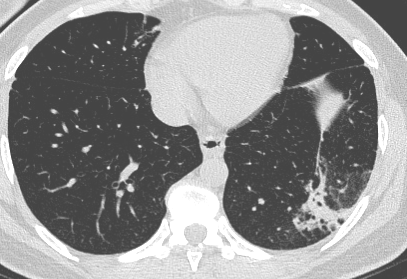

In [6]:
COVID = list(data_dir.glob('COVID/*.png'))
Image.open(COVID[33])

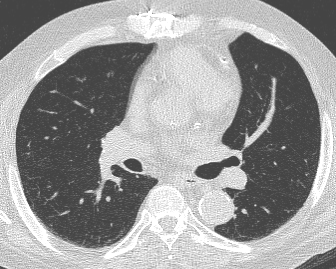

In [7]:
COVID = list(data_dir.glob('COVID/*.png'))
Image.open(COVID[30])

Here is the CT-scan images of two Non-COVID cases (negative COVID).

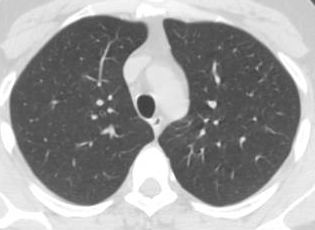

In [8]:
Non_COVID = list(data_dir.glob('Non_COVID/*.png'))
Image.open(Non_COVID[40])

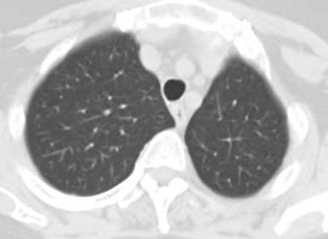

In [9]:
Non_COVID = list(data_dir.glob('Non_COVID/*.png'))
Image.open(Non_COVID[320])

### Covert CT-scan images to Numpy arrays

In [10]:
folders = os.listdir(data_dir)
folders

['Non_COVID', 'COVID']

We make a dictionary to assign a name to each image in a folder.

In [11]:
CT_image_dict = {}
CT_image_dict['COVID'] = list(data_dir.glob('COVID' + '/*.png'))
CT_image_dict['Non_COVID'] = list(data_dir.glob('Non_COVID' + '/*.png'))

We make a dictionary to assign a class number to each image. Positive COVID cases have class = 1 (COVID) and negative COVID cases have class = 0 (Non-COVID). 

In [12]:
CT_labels_dict = {}
CT_labels_dict['COVID'] = 1
CT_labels_dict['Non_COVID'] = 0

Here is an example of COVID class from dictionary.

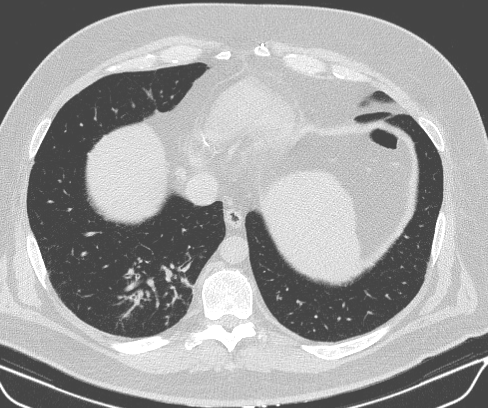

In [13]:
Image.open(CT_image_dict['COVID'][36])

Here is an example of Non-COVID class from dictionary.

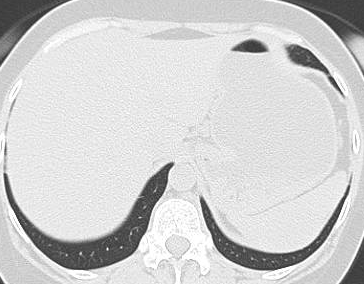

In [14]:
Image.open(CT_image_dict['Non_COVID'][37])

In this part, we change the size of images to 224x224x3 because DenseNet and Inception models work with this size of image. After that, we convert X and y to Numpy arrays. 

In [15]:
X, y = [], []

for COVID_result, images in CT_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224))
        X.append(resized_img)
        y.append(CT_labels_dict[COVID_result])

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
X.shape

(2481, 224, 224, 3)

In [18]:
y.shape

(2481,)

A random example of positive COVID case with class = 1:

1

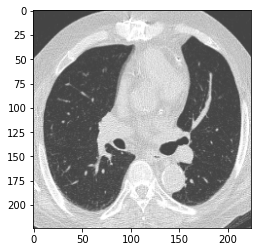

In [19]:
plt.imshow(X[30])
y[30]

A random example of negative COVID case with class = 0:

0

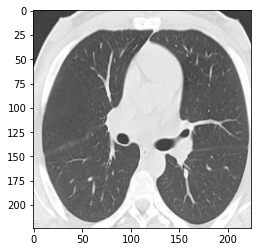

In [20]:
plt.imshow(X[2100])
y[2100]

### Split data into training and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [22]:
X_train_scaled = []
X_test_scaled = []

for ii in X_train:
    X_train_scaled.append(ii/255)

for ii in X_test:
    X_test_scaled.append(ii/255)

In [23]:
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)

In [24]:
X_train_scaled.shape

(1984, 224, 224, 3)

In [25]:
X_test_scaled.shape

(497, 224, 224, 3)

### Import DenseNet121 layers from TensorFlow Hub

In [26]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [27]:
base_model_DenseNet121 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape = IMG_SHAPE
)

In this part, we freeze the first 100 layers of the DenseNet121 because we do not want to update the weights of these layers.

In [28]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_DenseNet121.layers[:fine_tune_at]:
    layer.trainable = False


Here we add one Dense layer with 2 neurons at the end of the network, corresponding to two classes in this project.

In [29]:
x_input = tfl.Input(shape = IMG_SHAPE)
x = base_model_DenseNet121(x_input)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout (0.2)(x)
outputs = tfl.Dense(2)(x)
model_DenseNet121 = tf.keras.Model(x_input, outputs)

In [30]:
model_DenseNet121.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model_DenseNet121.fit(X_train_scaled, y_train, epochs = 10)

Epoch 1/10
62/62 [==============================] - 62s 611ms/step - loss: 0.3019 - accuracy: 0.8805
Epoch 2/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0838 - accuracy: 0.9698
Epoch 3/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0482 - accuracy: 0.9814
Epoch 4/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0542 - accuracy: 0.9819
Epoch 5/10
62/62 [==============================] - 38s 610ms/step - loss: 0.0613 - accuracy: 0.9743
Epoch 6/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0294 - accuracy: 0.9914
Epoch 7/10
62/62 [==============================] - 38s 610ms/step - loss: 0.0168 - accuracy: 0.9945
Epoch 8/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0512 - accuracy: 0.9814
Epoch 9/10
62/62 [==============================] - 38s 612ms/step - loss: 0.0268 - accuracy: 0.9904
Epoch 10/10
62/62 [==============================] - 38s 611ms/step - loss: 0.0172 - accura

The accuracy of DenseNet121 model on test dataset is 0.90 which is very good.

In [32]:
model_DenseNet121.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 8s 393ms/step - loss: 0.3595 - accuracy: 0.9014


[0.35949522256851196, 0.9014084339141846]

In [33]:
y_predicted = model_DenseNet121.predict(X_test_scaled)

In [34]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]

Text(114.0, 0.5, 'Truth')

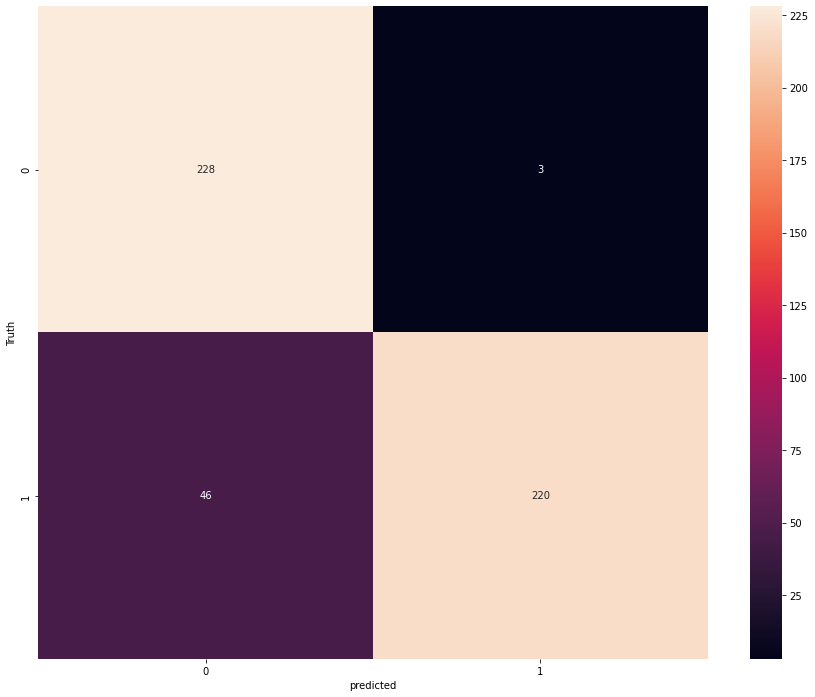

In [35]:
# Let's visualize this confusion matrix in seaborn
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (15, 12))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

The F-score for both classes is 0.9. The weighted average F-score is also 0.9 for DenseNet121 model.

In [36]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       231
           1       0.99      0.83      0.90       266

    accuracy                           0.90       497
   macro avg       0.91      0.91      0.90       497
weighted avg       0.91      0.90      0.90       497



### Import InceptionV3 layers from TensorFlow Hub

In [37]:
base_model_InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape = IMG_SHAPE
)

In [38]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_InceptionV3.layers[:fine_tune_at]:
    layer.trainable = False

In [39]:
x_input = tfl.Input(shape = IMG_SHAPE)
x = base_model_InceptionV3(x_input)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout (0.2)(x)
outputs = tfl.Dense(2)(x)
model_InceptionV3 = tf.keras.Model(x_input, outputs)

In [40]:
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model_InceptionV3.fit(X_train_scaled, y_train, epochs = 10)

Epoch 1/10
62/62 [==============================] - 40s 470ms/step - loss: 0.3193 - accuracy: 0.8750
Epoch 2/10
62/62 [==============================] - 29s 473ms/step - loss: 0.1003 - accuracy: 0.9622
Epoch 3/10
62/62 [==============================] - 29s 470ms/step - loss: 0.0454 - accuracy: 0.9849
Epoch 4/10
62/62 [==============================] - 29s 469ms/step - loss: 0.0532 - accuracy: 0.9839
Epoch 5/10
62/62 [==============================] - 29s 473ms/step - loss: 0.0160 - accuracy: 0.9950
Epoch 6/10
62/62 [==============================] - 29s 469ms/step - loss: 0.0604 - accuracy: 0.9814
Epoch 7/10
62/62 [==============================] - 29s 468ms/step - loss: 0.0140 - accuracy: 0.9970
Epoch 8/10
62/62 [==============================] - 29s 469ms/step - loss: 0.0289 - accuracy: 0.9899
Epoch 9/10
62/62 [==============================] - 29s 473ms/step - loss: 0.0057 - accuracy: 0.9980
Epoch 10/10
62/62 [==============================] - 29s 476ms/step - loss: 0.0060 - accura

The accuracy of InceptionV3 model on test dataset is 0.97 which is significantly higher than accuracy of DenseNet121 model (0.9).

In [42]:
model_InceptionV3.evaluate(X_test_scaled, y_test)

16/16 [==============================] - 7s 341ms/step - loss: 0.0914 - accuracy: 0.9678


[0.09137758612632751, 0.9678068161010742]

In [43]:
y_predicted = model_InceptionV3.predict(X_test_scaled)

In [44]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]

Text(114.0, 0.5, 'Truth')

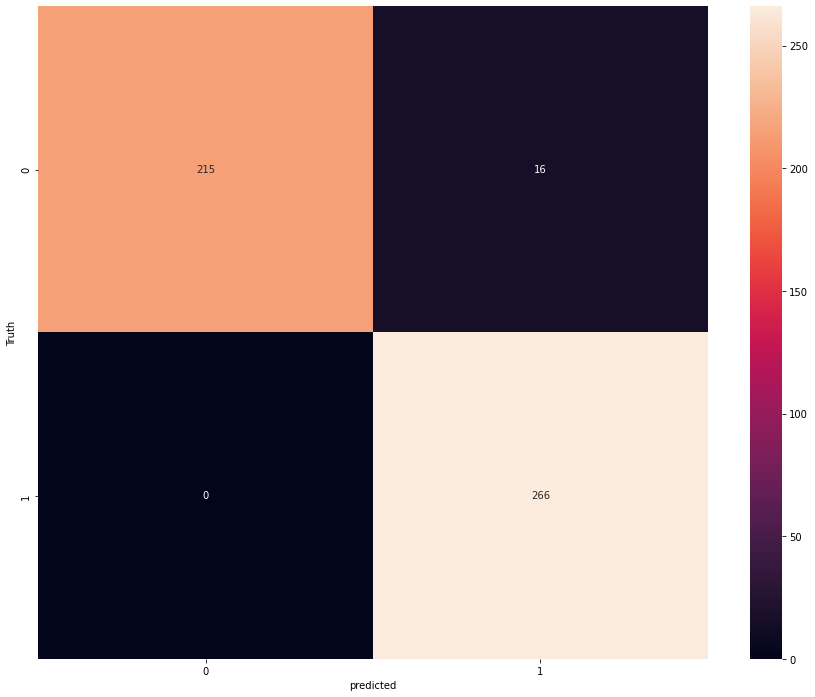

In [45]:
# Let's visualize this confusion matrix in seaborn
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (15, 12))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

The F-score for class 0 and 1 are 0.96 and 0.97, respectively. The weighted average F-score of InceptionV3 is 0.97 which is significantly higher than the weighted average F-score of DenseNet121 (0.9).

In [46]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       231
           1       0.94      1.00      0.97       266

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



### This is the end of this notebook.